# Python Machine Learning - Code Examples


# Chapter 3 - A Tour of Machine Learning Classifiers Using Scikit-Learn
# LR SVM DT  RF KNN 

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

*The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

### Overview

- [Choosing a classification algorithm](#Choosing-a-classification-algorithm)
- [First steps with scikit-learn](#First-steps-with-scikit-learn)
    - [Training a perceptron via scikit-learn](#Training-a-perceptron-via-scikit-learn)
- [Modeling class probabilities via logistic regression](#Modeling-class-probabilities-via-logistic-regression)
    - [Logistic regression intuition and conditional probabilities](#Logistic-regression-intuition-and-conditional-probabilities)
    - [Learning the weights of the logistic cost function](#Learning-the-weights-of-the-logistic-cost-function)
    - [Training a logistic regression model with scikit-learn](#Training-a-logistic-regression-model-with-scikit-learn)
    - [Tackling overfitting via regularization](#Tackling-overfitting-via-regularization)
- [Maximum margin classification with support vector machines](#Maximum-margin-classification-with-support-vector-machines)
    - [Maximum margin intuition](#Maximum-margin-intuition)
    - [Dealing with the nonlinearly separable case using slack variables](#Dealing-with-the-nonlinearly-separable-case-using-slack-variables)
    - [Alternative implementations in scikit-learn](#Alternative-implementations-in-scikit-learn)
- [Solving nonlinear problems using a kernel SVM](#Solving-nonlinear-problems-using-a-kernel-SVM)
    - [Using the kernel trick to find separating hyperplanes in higher dimensional space](#Using-the-kernel-trick-to-find-separating-hyperplanes-in-higher-dimensional-space)
- [Decision tree learning](#Decision-tree-learning)
    - [Maximizing information gain – getting the most bang for the buck](#Maximizing-information-gain-–-getting-the-most-bang-for-the-buck)
    - [Building a decision tree](#Building-a-decision-tree)
    - [Combining weak to strong learners via random forests](#Combining-weak-to-strong-learners-via-random-forests)
- [K-nearest neighbors – a lazy learning algorithm](#K-nearest-neighbors-–-a-lazy-learning-algorithm)
- [Summary](#Summary)

<br>
<br>

<br>
<br>

In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# Choosing a classification algorithm

...

# First steps with scikit-learn

從scikit學習載入Iris數據集。 這裡，第三列表示花瓣長度，第四列表示花樣的花瓣寬度。 這些類已經轉換為整數標籤，其中0 = Iris-Setosa，1 = Iris-Versicolor，2 = Iris-Virginica。

In [4]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

('Class labels:', array([0, 1, 2]))


將數據隨機分為30％(45個樣品)的訓練和70％(105個樣品)的測試數據：

In [5]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

標準化功能：
fit計算要用於之後縮放的平均值和標準差
transform通過對中和縮放執行標準化

In [6]:
from sklearn.preprocessing import StandardScaler  #特徵標準化

sc = StandardScaler()
sc.fit(X_train)  #會對訓練數據集中每個估計參數"特徵維度參數和標準差
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test) #我們對訓練數據集和測試數據集會有相同的"正規化"參數，這樣一來，"標準化"的值才能互相比較

## 正規化訓練數集後，來做感知器模型訓練
<br>
<br>

## Training a perceptron via scikit-learn

Redefining the `plot_decision_region` function from chapter 2:

n_iter : int, optional
訓練數據的次數。預設為5。

eta0 : double
更新的數據乘以一個常數 預設1.

random_state : int seed, RandomState instance, or None (default)
虛擬隨機數生成器的種子在混洗數據時使用。

In [7]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [8]:
y_test.shape

(45L,)

In [9]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 4


### 測試數據集的45個樣本，有4個被感知器錯誤分類
### 錯誤率4/45=0.089
### 正確率=1-0.089=0.911

In [10]:
from sklearn.metrics import accuracy_score

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))#y_test真正的類別標籤，y_pred預測的類別標籤

Accuracy: 0.91


In [11]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings


def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

## 使用標準化訓練數據訓練感知器模型：

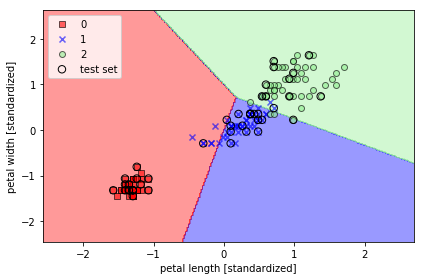

In [12]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/iris_perceptron_scikit.png', dpi=300)
plt.show()

## 這是利用"感知器演算法"所做的分類，由圖中得知，感知器演算法在處理非線性分類的數據集時，演算法不會收斂，所以實務上不推薦使用感知器演算法，所以以下方法具有線性分類的特性，在數據是非線性分類時，他們也能收斂到最小成本

## 使用CH2 plot_decision_regions 繪製決策區域圖，以小圓圈來凸顯測試數據集
## 上圖無法用線性決策突來完美分隔

<br>
<br>

# Modeling class probabilities via logistic regression
http://arbu00.blogspot.tw/2017/02/5-logistic-regressionoverfitting-and.html

...

### 邏輯回歸直覺和條件概率

## 邏輯斯迴歸模型(Logistic regression)使用啟動函數稱之為sigmoid函數：

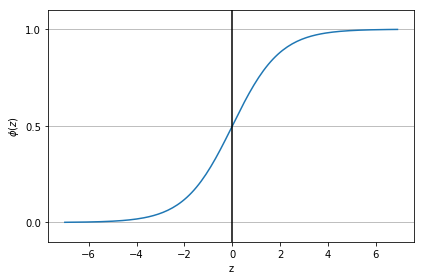

In [13]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
# plt.savefig('./figures/sigmoid.png', dpi=300)
plt.show()

## 當z越大時，Φ(z)趨近於1
## 當z越小時，Φ(z)趨近於0

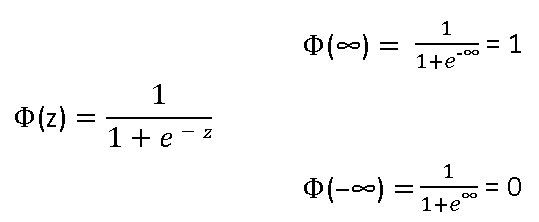

In [14]:
Image(filename='./images/03-61.png', width=500) 

## z為淨輸入:

In [15]:
Image(filename='./images/input.png', width=500) 

## 其sigmoid函數圖型看似為S形狀。淨輸入z當作sigmoid函數的輸入後，會被轉成0.0~1.0的實數分布，如果截距給定0.5，那我們可以利用二元量化器，如果Φ(z)>=0.5 便分為正類，反之分為負類。sigmoid函數的輸出可以解釋為"某特定樣本，給定特徵x與加權w，當參數時屬於類別1的機率"：

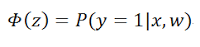

In [16]:
Image(filename='./images/q26.png', width=500) 

## 給定特徵x與加權y當參數時，屬於1的機率
## 例如以之前的鳶尾花樣本為分類範例，如果計算出某特定樣本Φ(z)=0.8，而分類1假設為樣本Iris-Versicolor，那麼意味著該特定樣本有80%的機率是屬於Iris-Versicolor分類：而屬於另一樣本(假設為Iris-Setosa)的機率為20%。可以底下公式算出：

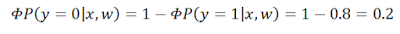

In [17]:
Image(filename='./images/q27.png', width=500) 

## 接著，便可以使用一量化器，將預測機率轉換成二元分類的結果：

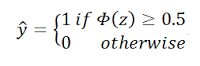

In [18]:
Image(filename='./images/q28.png', width=500) 

## 對應sigmoid函數，z為淨輸入：

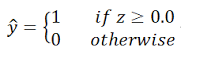

In [19]:
Image(filename='./images/q29.png', width=500) 

## 原因是當輸入z為趨近於正無限大，那麼Φ(z)輸出會趨近於1.0，輸入z為趨近於負無限大，那麼Φ(z)輸出會趨近於0.0

## 事實上，我們不僅對預測"類別標籤"感興趣，估計樣本屬於某類別的機率，是非常有用的，邏輯迴歸不僅預測某一天是否會下雨，也提供下雨的機率。同樣的，如果病患有某些特定症狀，也可用"邏輯迴歸"來預測病患得到某種特定疾病的機率。

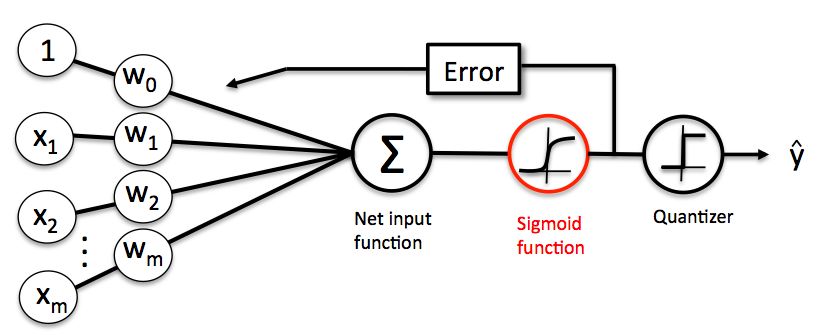

In [20]:
Image(filename='./images/03_03.png', width=500) 

### Learning the weights of the logistic cost function

## 為了解釋如何推導邏輯斯迴歸模型的成本函數，我們先定義"概似"L(likelihood)，我們期望L最大，也就是我們期望"某特定樣本屬於某一特定分類的機率最大"。假設我們數據集中的各個樣本是互相獨立的，那麼計算L的公式如下：

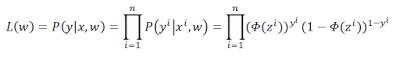

In [21]:
Image(filename='./images/q30.png', width=700) 

## 要對上述公式求取最大化，可以對這個公式套用自然對數函數，這就是所謂的"對數概似函數"(log-likelihood function)：

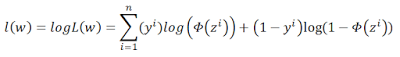

In [22]:
Image(filename='./images/q31.png', width=700) 

## 現在可以使用最佳化演算法，如梯度上升法來最大化這個概似函數，在此我們也可以把這個概似函數寫為成本函數，也就是取負，讓函數開口變上，那麼就可以反過來使用之前所說的梯度下降法(GD)來最小化這個成本函數J(w)：

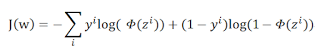

In [23]:
Image(filename='./images/q22.png', width=700) 

## 為了更理解這個成本函數，讓我們來看看單一實例的成本如何計算：

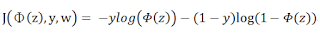

In [24]:
Image(filename='./images/q32.png', width=700) 

## 觀上述方程式如果y=0，那麼第一項為0，如果y=1，那麼第二項為0，如下所示：

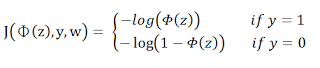

In [25]:
Image(filename='./images/q33.png', width=500) 

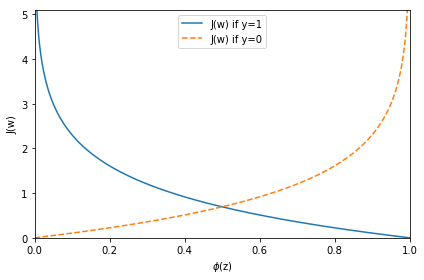

In [26]:
def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/log_cost.png', dpi=300)
plt.show()

## 如果我們正確預測，一個樣本屬於1這類，那麼成本(x軸)會接近0(實心線)

## 同樣的，如果我們正確地預測y=0(虛線)，可以看到y軸上的成本也接近0，然而，如果預測錯誤，成本就會變成無限大

### Training a logistic regression model with scikit-learn

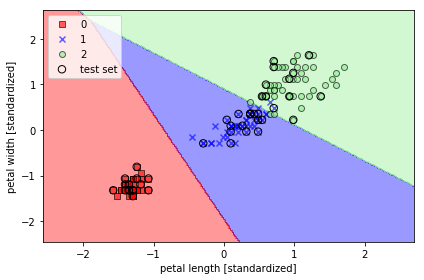

In [27]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/logistic_regression.png', dpi=300)
plt.show()

In [28]:
if Version(sklearn_version) < '0.17':
    lr.predict_proba(X_test_std[0, :])
else:
    lr.predict_proba(X_test_std[0, :].reshape(1, -1))

## 邏輯迴歸藉由梯度下降所得到的加權更新值，就是CH2的Adaline所用得公式，讓我們計算"對數概似函數"相對於第j個加權的偏倒數，來開始證明

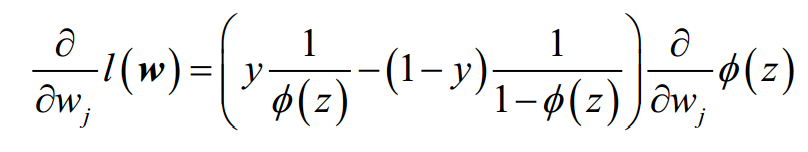

In [29]:
Image(filename='./images/03-24.png', width=500) 

## 先計算sigmoid函數的偏倒數

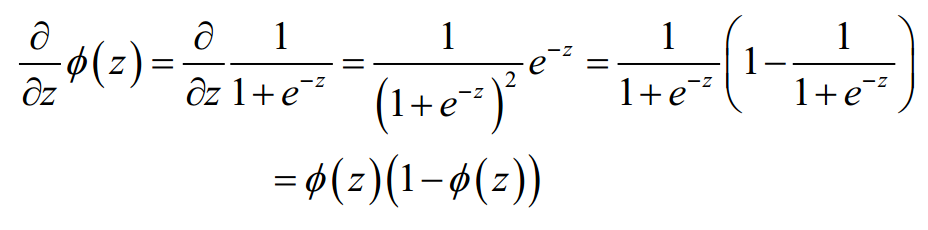

In [30]:
Image(filename='./images/03-25.png', width=500) 

我們的03-25.png的公式可以替代成

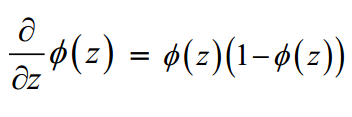

In [31]:
Image(filename='./images/03-31.png', width=300) 

如下

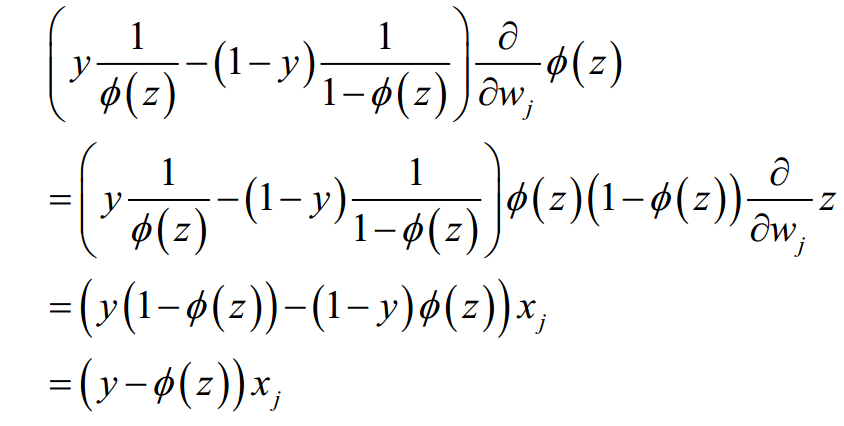

In [32]:
Image(filename='./images/03-26.png', width=500) 

## 我們的目標是找到最大的"對數概似"，這樣一來我們能為每個加權，去做以下方式進行更新

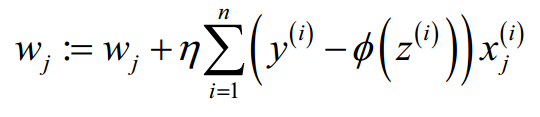

In [33]:
Image(filename='./images/03-27.png', width=500) 

## 由於我們同時更新所有加權時，我們可以更新規則，一般化程如下式子

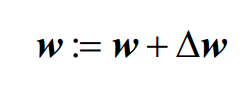

In [34]:
Image(filename='./images/03-28.png', width=300) 

## delta w定義如下

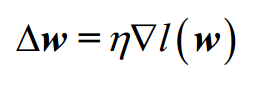

In [35]:
Image(filename='./images/03-29.png', width=300) 

### 由於最大化"對數概似"最小化我們之前定義的"成本函數"J，因此"梯度下降"更新規則，就可以下以下公式

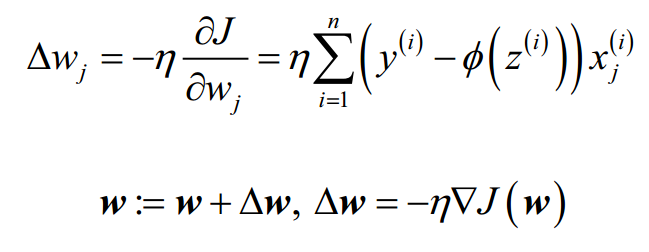

In [36]:
Image(filename='./images/03-30.png', width=400) 

### 這與CH2的Adaline所用的梯度下降規則相同

### Tackling overfitting via regularization
### 以正規化(regularization)處裡高度適合(overfitting)現象：


### 若想要在偏誤-變異數(bias-variance)之間找一個平衡，其中一個方法是透過"正規化"(regularization)來調整模型複雜度。

### 高度適合(overfitting )是機器學習常見的一種現象，意旨一個模型在對"訓練數據集"時有很好的效能，但是面對"未知的數據集"或是"測試數據集"時，卻效能不佳。如果該模型有高度適合(overfitting )現象，也代表著有高變異性(high variance)其產生的原因可能是使用"過多的特徵"，而相反的低度適合(underfitting)則代表有著高偏誤(high bias)，其模型在訓練樣本時無法訓練出適合的模式，而在面對"未知的數據"時，通常也不會有好的效能。

### 變異數(variance)可以測量該模型對特定樣本，預測能力的一致性或是變異性，也就是說該模型對訓練數據的隨機性，是否反應良好。
### 偏誤(bias)一般而言是測量預測正確值的偏離，在於描述不是由隨機性所產生的系統誤差

### 可以用下圖來理解這些狀況：

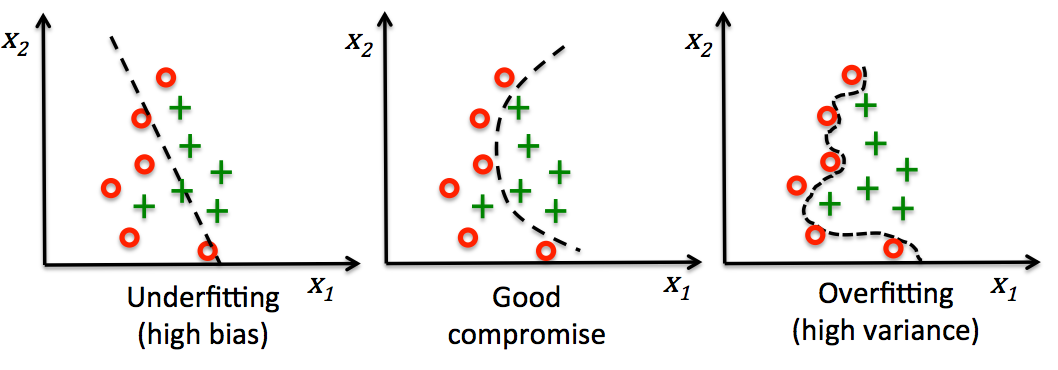

In [37]:
Image(filename='./images/03_06.png', width=700) 

## 若想要在"偏誤(bias)-變異數(variance)"之間找到一個平衡，其中一個方法是透過正規化(regularization)，來調整模型的複雜度。正規化(regularization)防止高度適合(overfitting )的觀念是，

## 加入更多的偏誤(bias)來懲罰極端的參數權重，最常見的是"L2正規化"，也被稱為L2收縮或加權衰減，其表示式為：

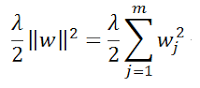

In [38]:
Image(filename='./images/q34.png', width=500) 

## λ稱之為正規化參數(regularization parameter)
## 要運用正規化，只需要將正規項加入成本函數，用它來縮小邏輯斯迴歸的加權，如下：

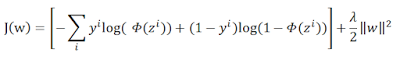

In [39]:
Image(filename='./images/q23.png', width=800) 

## 藉由正規化參數(regularization parameter)λ，我們可以讓加權保持很小。另一方面如果加大正規化參數(regularization parameter)λ，則可以增加正規化的強度。

## 在Scikit-learn 裡LogisticRegression類別的參數C，命名方式來自於SVM支援向量機，C定義為正規化參數(regularization parameter)λ的倒數：

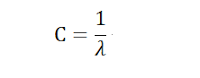

In [40]:
Image(filename='./images/q24.png', width=400) 

## 我們可以重寫邏輯斯迴歸的正規化成本函數：

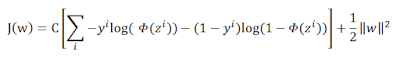

In [41]:
Image(filename='./images/q25.png', width=700) 

## 因此，降低反正規化參數(regularization parameter)C，也就是意謂著增加正規化參數(regularization parameter)λ的值，進而增加正規化強度，底下我們可以藉由繪製L2正規化兩個加權系數的變動路徑看出：
## 底下結果顯示將C變小，權重係數就會縮收，因此增加正規化強度。

## 反正規化參數(regularization parameter)C 對權重係數調整的影響

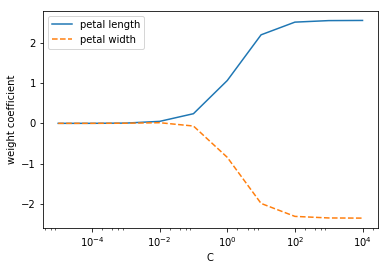

In [42]:
weights, params = [], []
for c in np.arange(-5., 5.):
    lr = LogisticRegression(C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
# plt.savefig('./figures/regression_path.png', dpi=300)
plt.show()

<br>
<br>

# Maximum margin classification with support vector machines
## Maximum margin intuition 直觀理解最大邊界

## SVM可被視為是"感知器"的延伸。使用"感知器演算法"來減少誤分，然而，在SVM的最佳化目標是：邊界(margin)被定義為"分離超平面"(separating hyperplane)，也就是"決策邊界"(decision boundary)和最接近該平面的"訓練樣本"之間的距離。

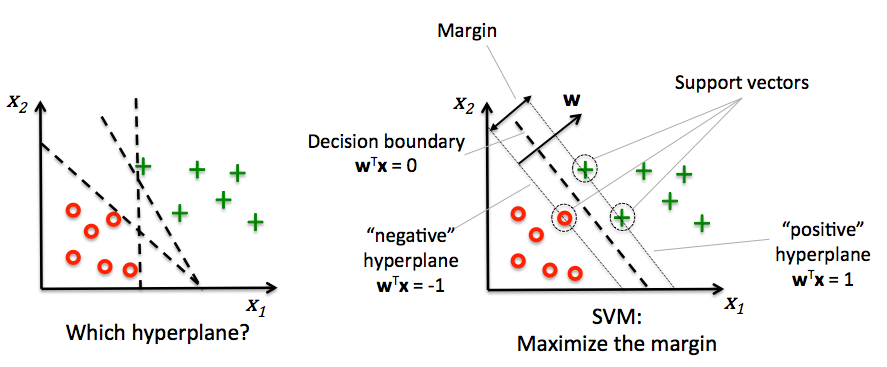

In [43]:
Image(filename='./images/03_07.png', width=700) 

### 我們希望追求擁有大邊界的"決策邊界"的理由是，他們往往有一個較低的"一般化誤差"(generalization error)，或者說，小邊界的模型，更容易發生overfitting，讓我們看看平行於"決策邊界"的"正超平面"(positive hyperplane)與"負超平面"(negative hyperplane)，他可以如下方式表示

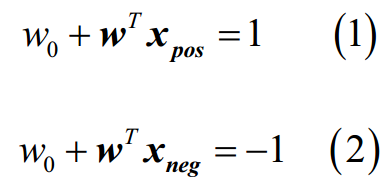

In [44]:
Image(filename='./images/03-32.png', width=300) 

### 如果將(1)-(2)

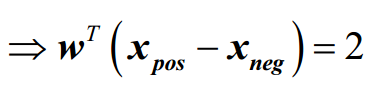

In [45]:
Image(filename='./images/03-33.png', width=300) 

### 可以使向量w的長度，來常態化(normalize)，w的長度定義如下

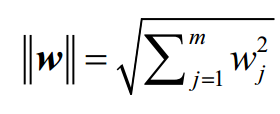

In [46]:
Image(filename='./images/03-34.png', width=300) 

### 得出以下公式

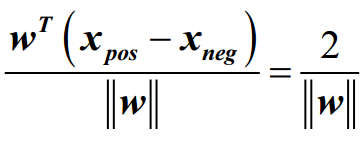

In [47]:
Image(filename='./images/03-35.png', width=300) 

### 上述方程的左項，可以解釋為"正超平面"和"負超平面"之間的距離，這是我們希望的最大化邊界
### 現在我們可以最大化方程的右項，來使SVM的"目標函數"成為該"邊界"的最大值，(假設樣本式被正確的分類)可以寫成以下式子

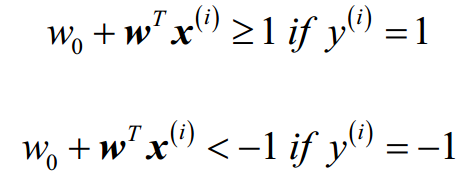

In [48]:
Image(filename='./images/03-36.png', width=300) 

### 這2個方程式是說，所有的負樣本，都應該落在負超平面的那一側。而所有的正樣本則落在正超平面的那一側，這可以更精簡的寫為

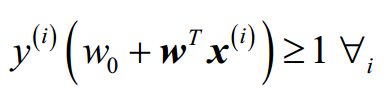

In [49]:
Image(filename='./images/03-37.png', width=300) 

### 閒置變數(slack variable)，具有適當"成本懲罰"(cost penaliztion)的錯誤分類的情況下，線性約束(linear constraint)需要被"鬆弛"(relax)，才能對"非線性分離"(nonlinear separable)數據收斂，並倒出最佳解
### 正的閒置變數被簡單加入線性約束裡面，如下

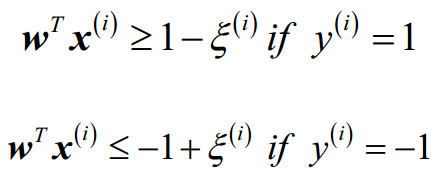

In [50]:
Image(filename='./images/03-38.png', width=300) 

### 因此，新的目標是找最小(相較於之前的約束)，如下

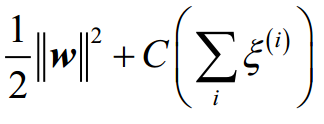

In [51]:
Image(filename='./images/03-39.png', width=300) 

### 使用變量C，可以控制錯誤分類的懲罰，C越小，對分類錯誤也越不嚴格，邊界則越大，反之則越小如以下圖示

## Dealing with the nonlinearly separable case using slack variables

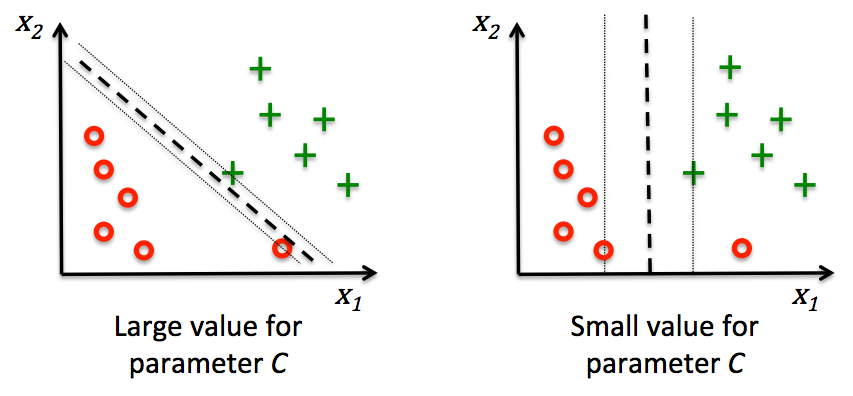

In [52]:
Image(filename='./images/03_08.png', width=600) 

### 增加C的值，會增加偏誤並降低模型的變異數

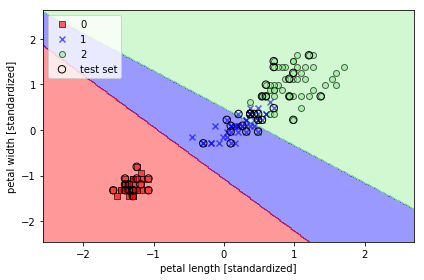

In [53]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=0.02, random_state=0) #使用線性SVM對iris做分類
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_linear.png', dpi=300)
plt.show()

### 線性邏輯迴歸 和 線性支援像量機 常常會產生非常相似的結果，但是線性邏輯迴歸試圖最大化訓練數據集的條件概似(conditional likelihood)，這會使邏輯迴歸比SVM更容易傾向離群值(outlier)。邏輯迴歸有另一個優點，他是一個簡單的模型，容易實做，另外，邏輯迴歸可以很容易的完成更新處理，這在處理串流數據的時候，是非常實用的。

## Alternative implementations in scikit-learn

In [54]:
from sklearn.linear_model import SGDClassifier
ppn=SGDClassifier(loss='perceptron')
lr=SGDClassifier(loss='log')
svm=SGDClassifier(loss='hinge')

#SGDClassifier 提供線上學習的機制，不會因為資料量太大導致記憶體不夠使用，CH2有說明

<br>
<br>

# Solving non-linear problems using a kernel SVM 核心SVM解決非線性問題

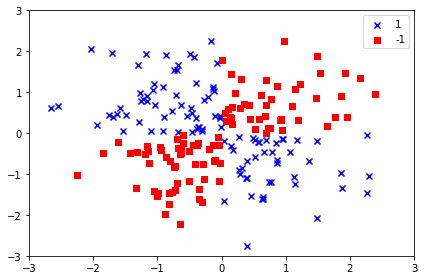

In [55]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
X_xor = np.random.randn(200, 2)   #利用亂數較XOR產生數據，其中100個被歸類於1，100個被歸類為-1
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/xor.png', dpi=300)
plt.show()

### 很明顯，無法用線性邏輯迴歸或線性SVM去做分類
### 核SVM面對非線性分離數據的想法是:產生"非線性組合"，藉由對應函數，將原本的特徵投影到更高維度空間中，而這個高維度空見是可以線性分離的，如下圖所示，我們將二維數據集轉到三維空間，透過這樣的投影類別是可以分離的

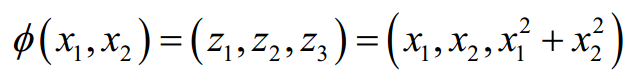

In [56]:
Image(filename='./images/03-42.png', width=400) 

### 這使我們能夠藉由一個現性超平面，分離兩類樣本，而如果我們將他們投影回去原來的二維空間，他就變成非線性的決策邊界

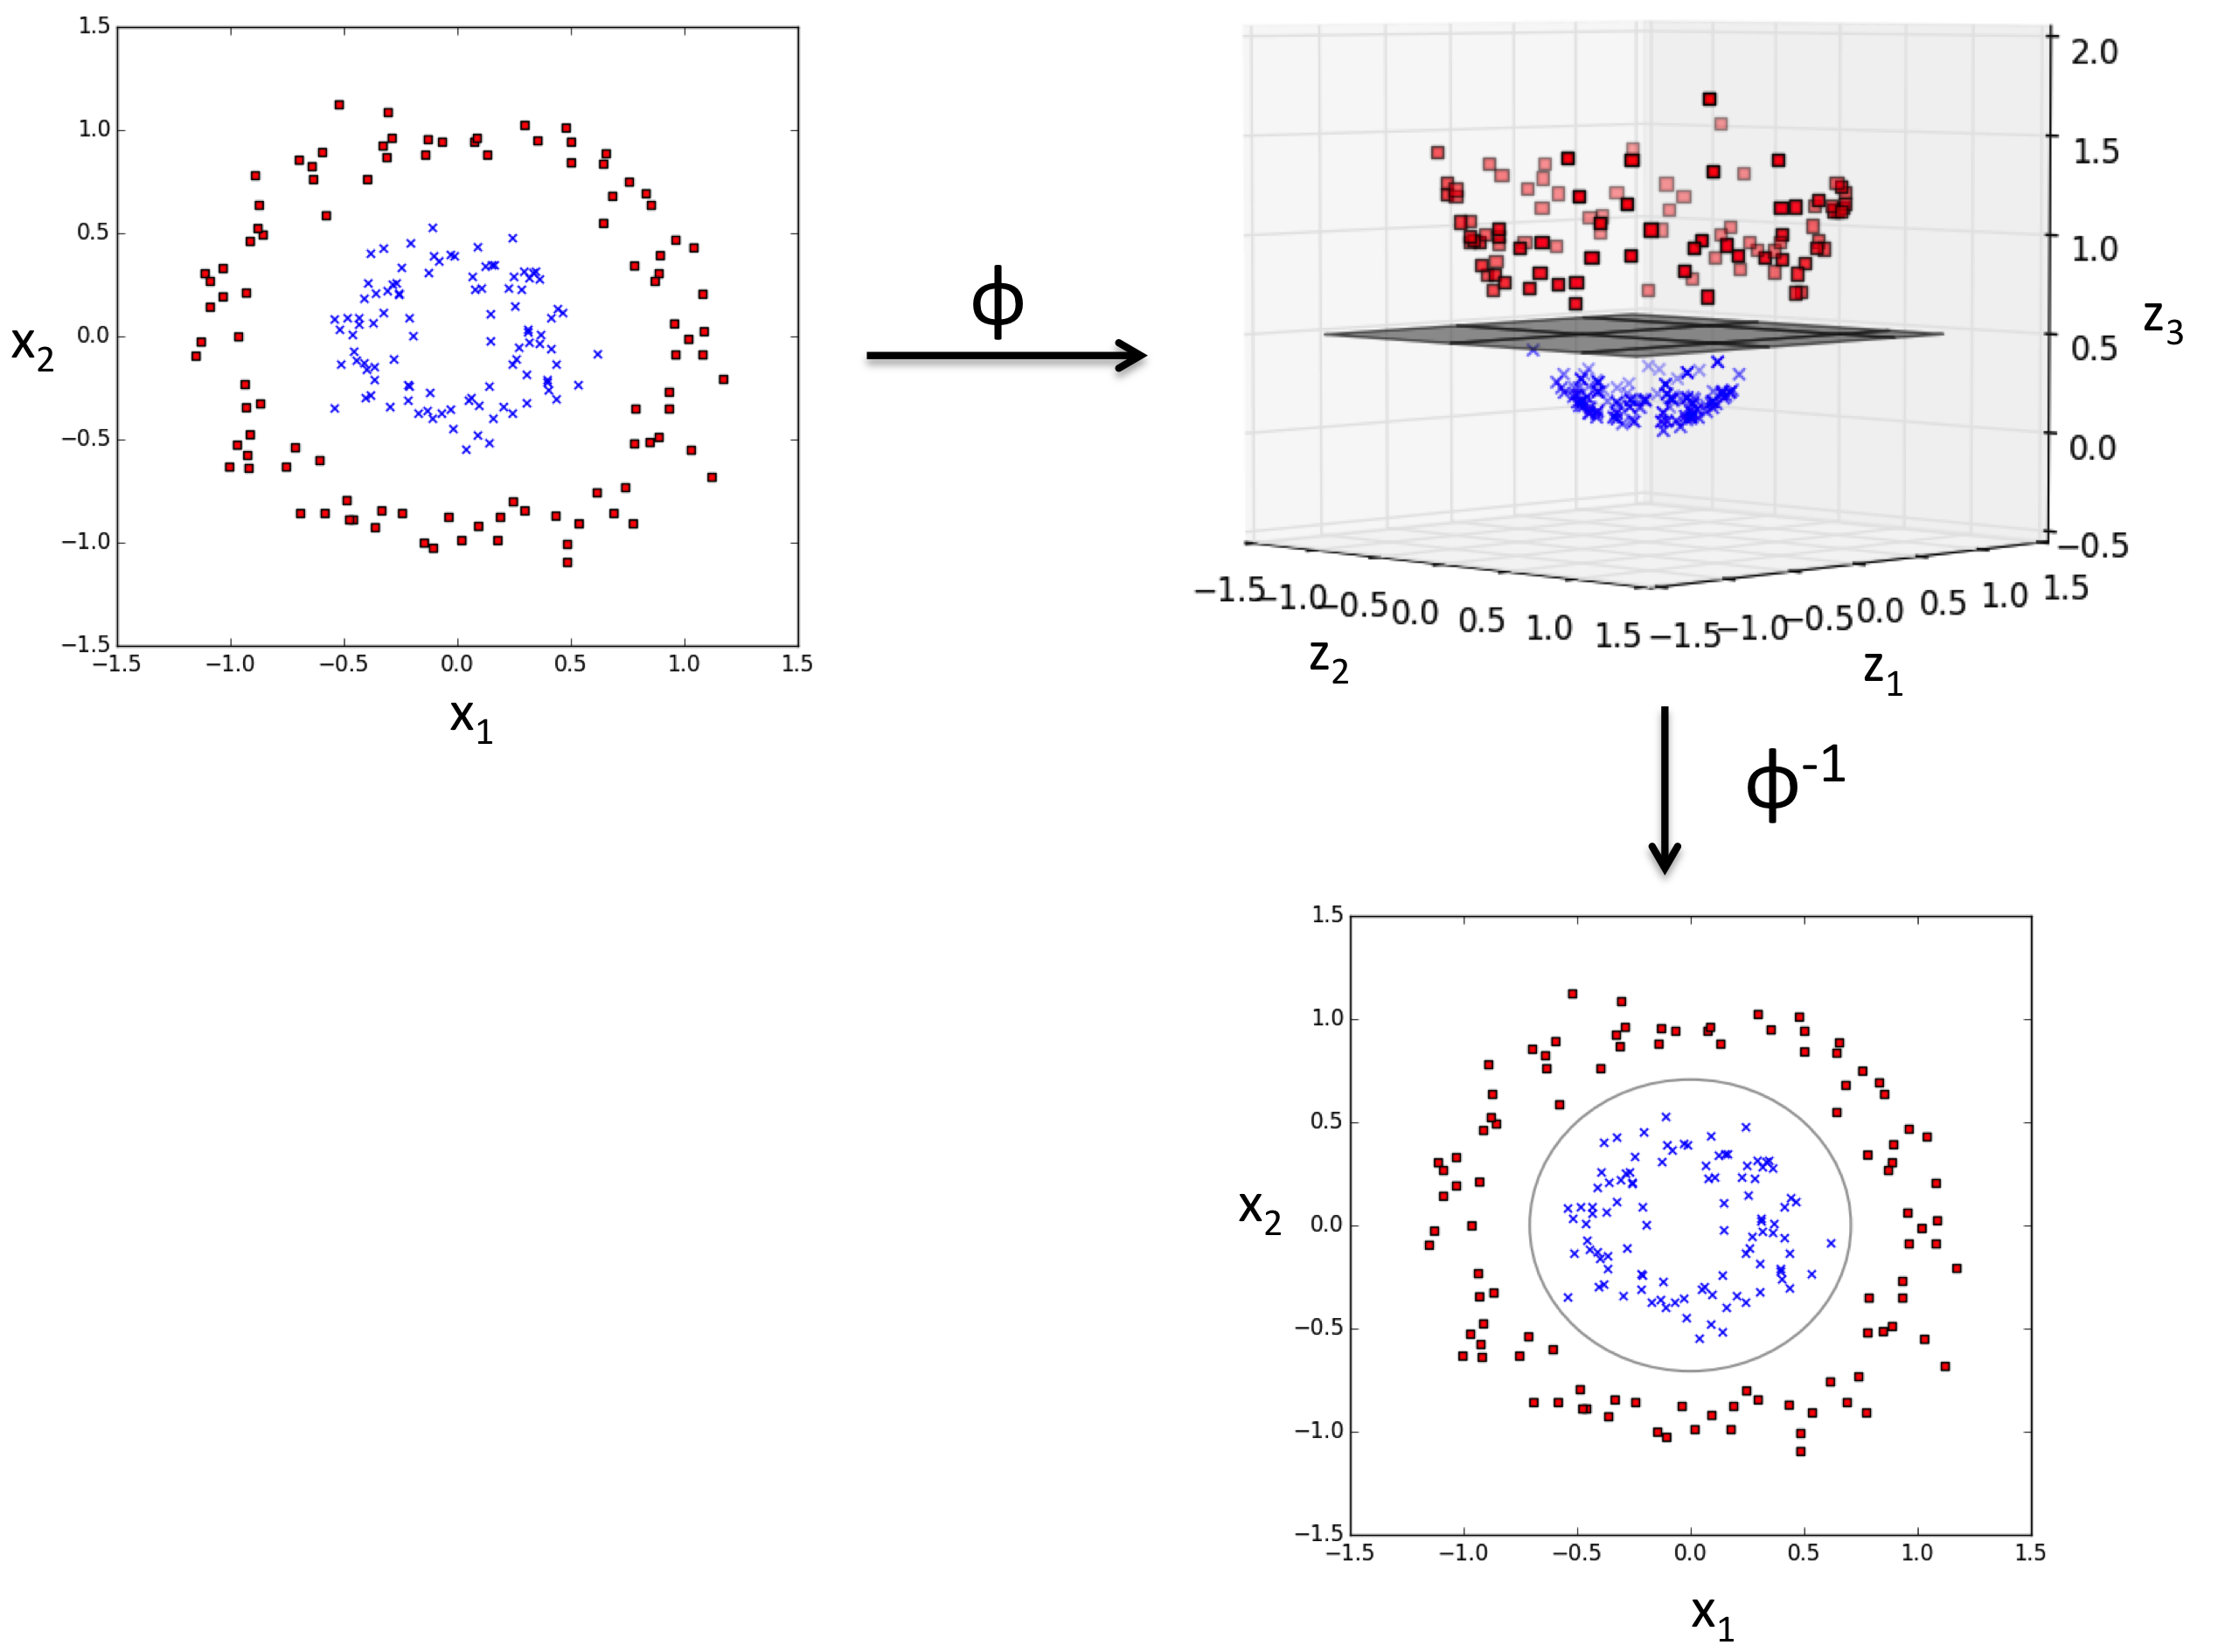

In [57]:
Image(filename='./images/03_11.png', width=700) 

<br>
<br>

## Using the kernel trick to find separating hyperplanes in higher dimensional space
## 使用核技巧在高維空間找到分離超平面

### 我們需要將向量內積x(i)T *x(j)置換為Φ(x(i)T) *Φx(j)，我們定義一個核函數如下

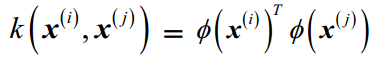

In [58]:
Image(filename='./images/03-43.png', width=400) 

### 其中被廣泛使用的核心是RBF(徑向基底函數核)或高斯核(Gaussian kernal)

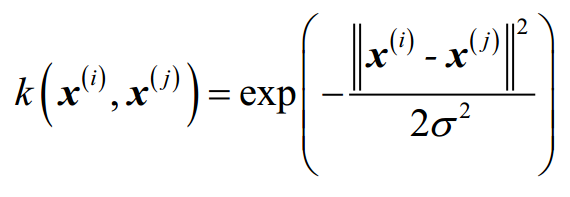

In [59]:
Image(filename='./images/03-44.png', width=400) 

### 可以看做兩個特徵向量之間的平方歐幾里得距離。 sigma 是一個自由參數。一種等價但更為簡單的定義是設一個新的參數 gamma 
### 可以簡化為

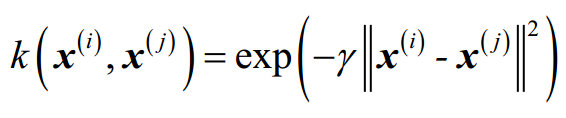

In [60]:
Image(filename='./images/03-45.png', width=400) 

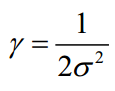

In [61]:
Image(filename='./images/03-46.png', width=200) 

### 以上是被最佳化的自由參數
### 核心 可被解釋為:對樣本之間的"相似度函數"(similarity function)，其中負號將距離反轉成相似度的分數，並且成為止數函數的關係，結果想似度的分數會落在1(相似的樣品)與0(不相似的樣品)之間

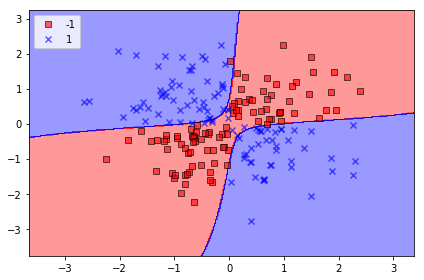

In [62]:
svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_xor.png', dpi=300)
plt.show()

### RBF 成功分離了數據集
### gamma為高斯球(gamma sphere)的截斷參數

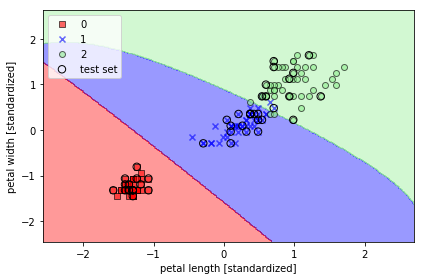

In [63]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=0, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_iris_1.png', dpi=300)
plt.show()

### 如果增加gamma，會產生較緊的決策邊界

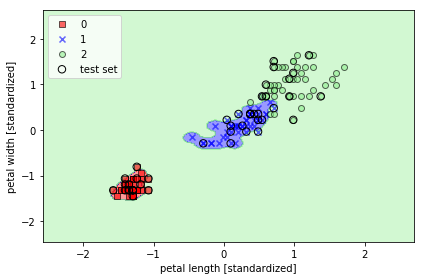

In [64]:
svm = SVC(kernel='rbf', random_state=0, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/support_vector_machine_rbf_iris_2.png', dpi=300)
plt.show()

<br>
<br>

# Decision tree learning

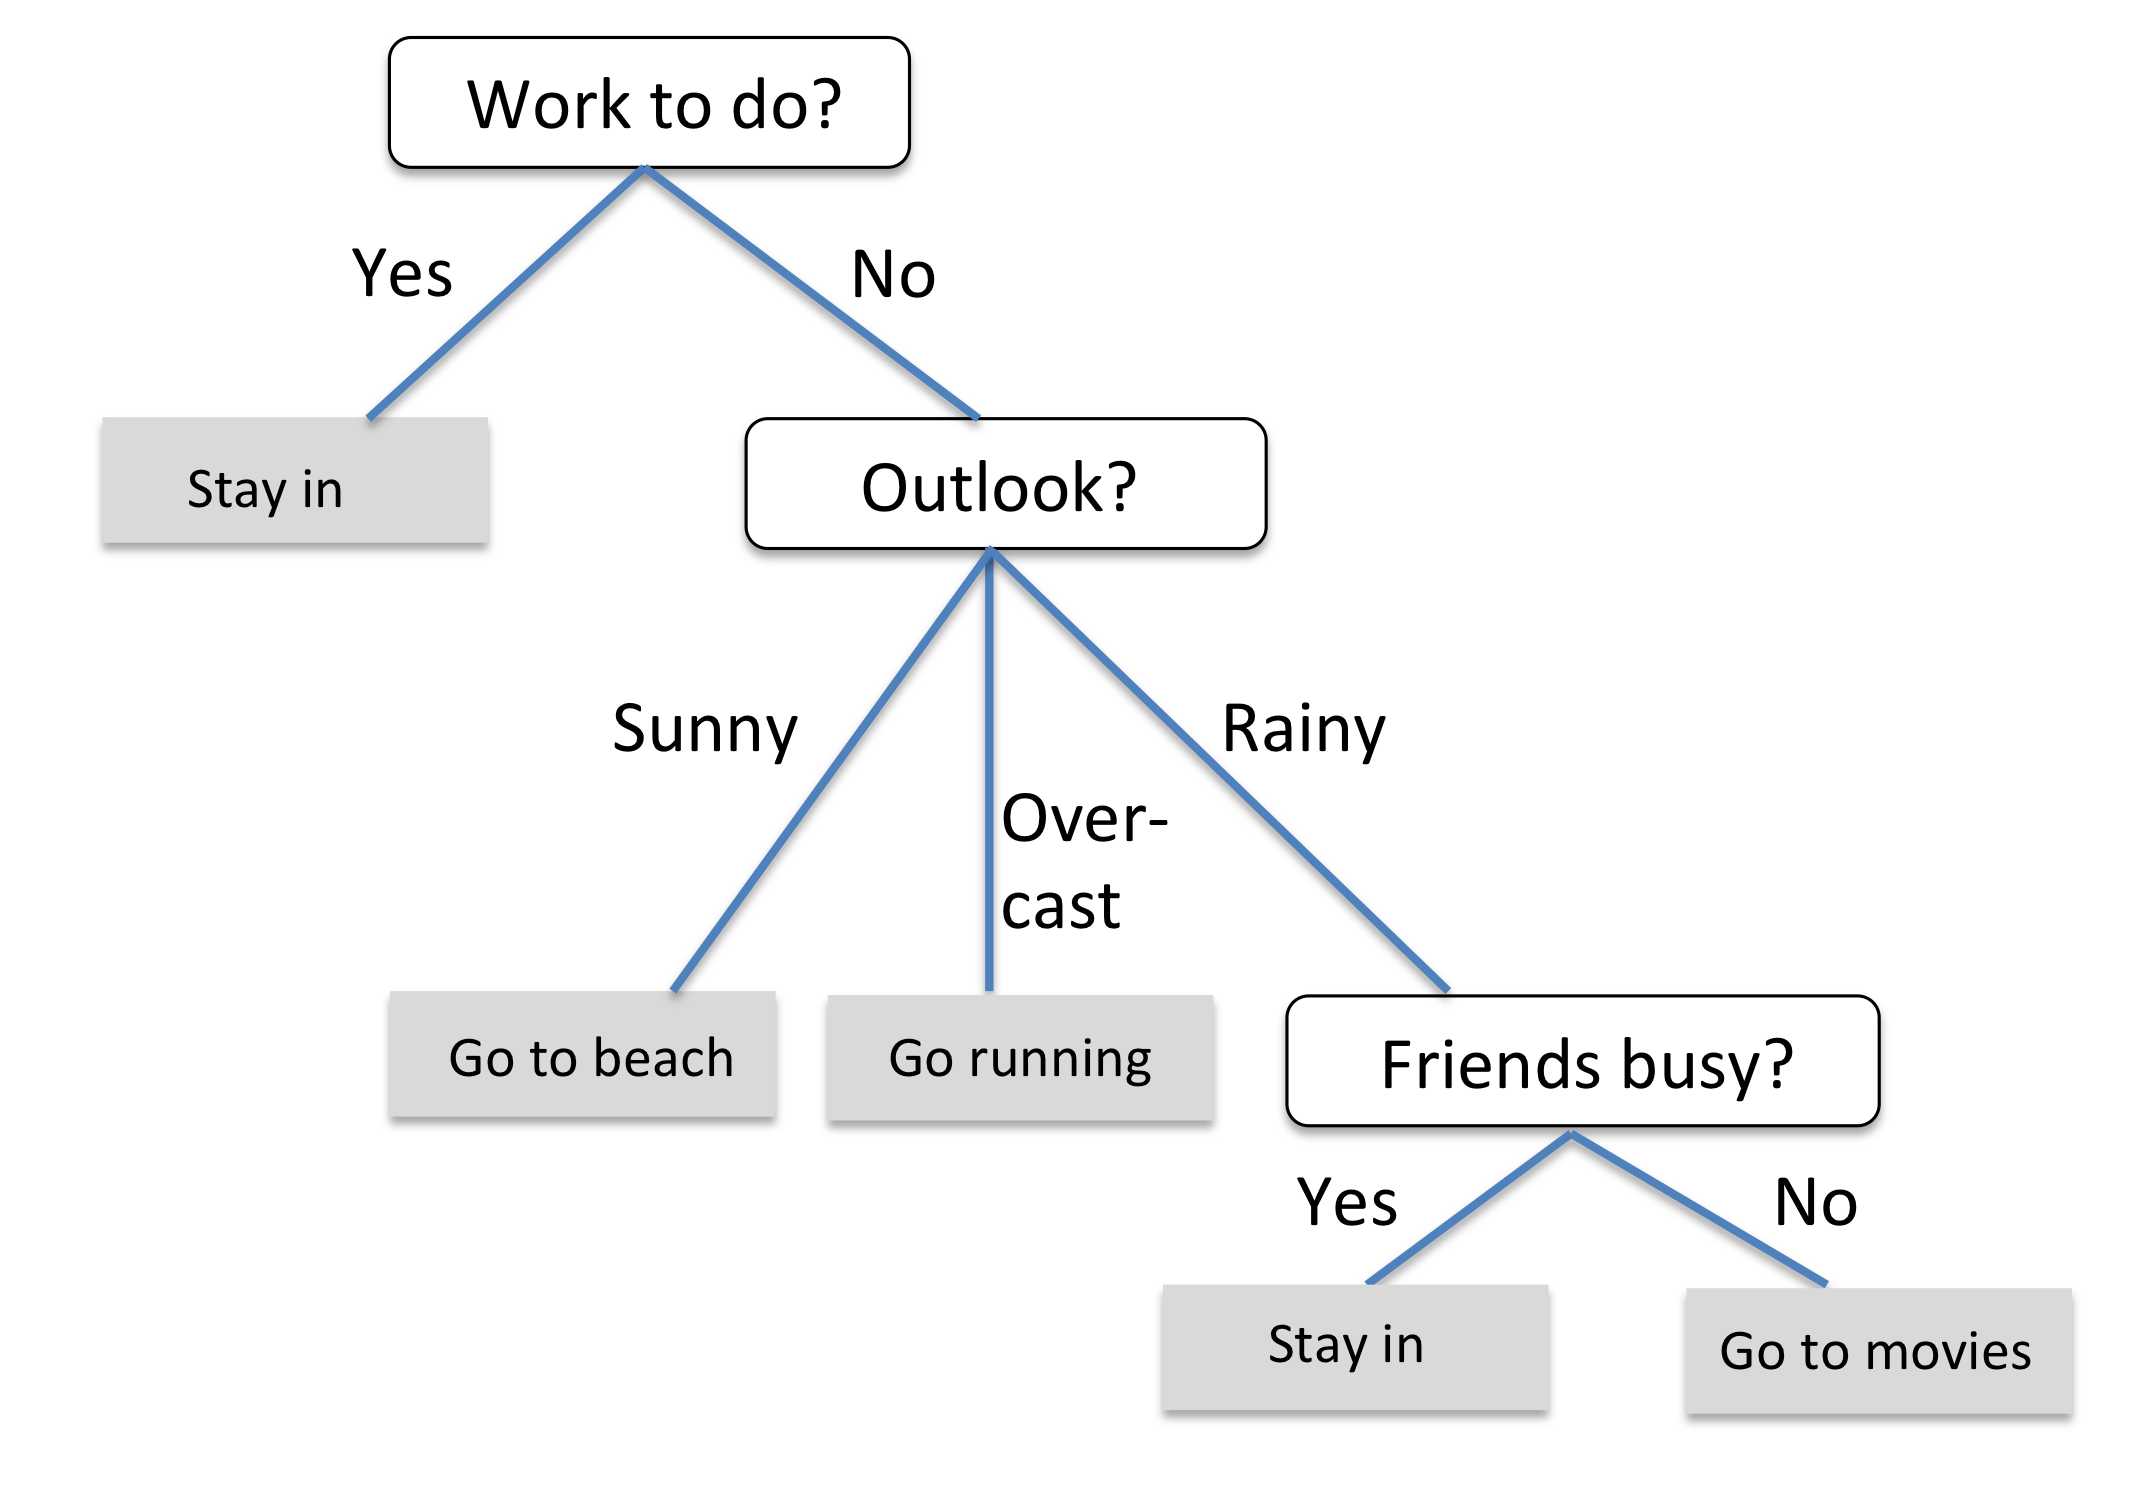

In [65]:
Image(filename='./images/03_15.png', width=500) 

### 使用DT，會從root開始，依據特徵將數據分割到不同邊，這樣會得到較大的資訊助益(information gain,IG)，在迭代過程中，在子節點中，重覆這種分割過程，直到leaf node，leaf node中的樣本都屬於同一類別，實作上，可能產生較大，較深的DT，會導致overfitting，因此會限定高度來預防過深得情況

## Maximizing information gain - getting the most bang for the buck
## 取得最大利益
### 我們希望最大化"目標函數"，目標函數定義成:每個分割處理，資訊增益必須最大，定義如下

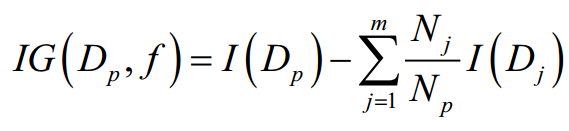

In [66]:
Image(filename='./images/03-47.png', width=400) 

### f是節點用來分割的特徵，Dp父節點的數據集，Dj第j點的子節點的數據集，I是"不純度"(impurity measure)，Np是父節點的個數，Nj第j點的子節點的個數
### 資訊增益(IG)是父節點的"不純度"與其子節點的"不純度"加總後的差，子節點的"不純度"加總(算式後項)愈小，則資訊增益越大
### 然而大部份的樹都是二元樹，所以會推倒以下公式

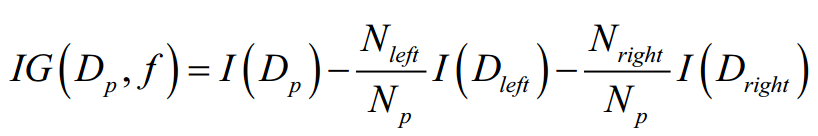

In [67]:
Image(filename='./images/03-48.png', width=500) 

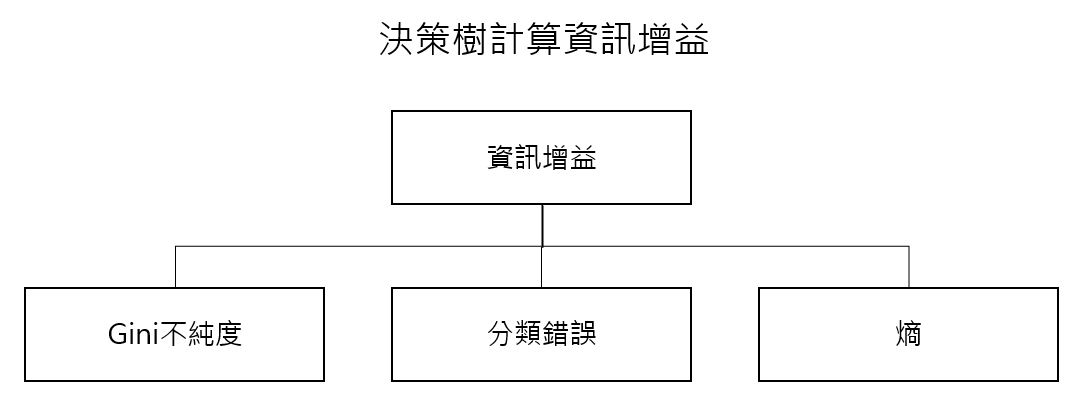

In [68]:
Image(filename='./images/03-59.png', width=600) 

### 在二元樹中，"不純度"被稱為分割條件，而方法有，"Gini不純度"(Gini impurity,Ig)，"熵"(entropy,Ih)與分類錯誤率(Ie)，首先是"熵"的定義

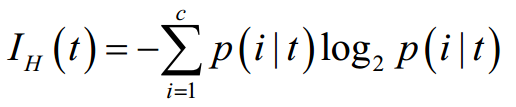

In [69]:
Image(filename='./images/03-49.png', width=400) 

### p(i|t)代表某特定節點t中，屬於類別 i 樣本的比例。如果在一個節點中的所有樣本，都屬於同一類，"熵"=0，如果是平均分布，則"熵"會最大，"熵"會最大化樹中節點的交互資訊(mutual information)

### Gini不純度可以理解為，最小化"錯誤分類"機率的準則，以下為公式

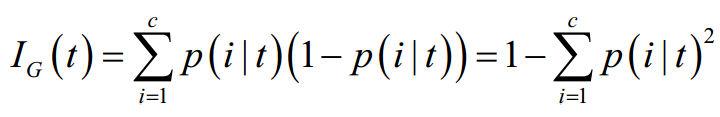

In [70]:
Image(filename='./images/03-50.png', width=500) 

### 類似"熵"，如果類別完美混雜，Gini不純度則會最大，EX:在一個二元分類的環境下(c=2)

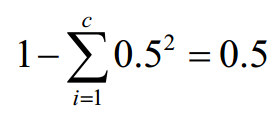

In [71]:
Image(filename='./images/03-51.png', width=300) 

### 在實務上，Gini不純度與"熵"通常會產生類似的結果，並不值得使用不同的不純度來評估決策樹。比較有意義的做法是，用不同的"截斷值"修剪決策樹，來比較結果
### 另一個不純度是"分類錯誤率"，以下是公式

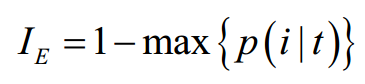

In [72]:
Image(filename='./images/03-52.png', width=300) 

## 修剪決策樹遠比建立一棵龐大的決策樹更可行，以下是2個可能的分割環境

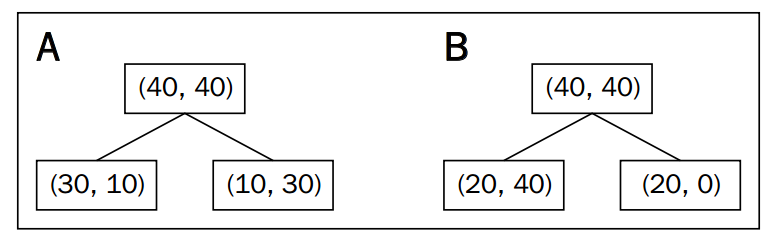

In [73]:
Image(filename='./images/03-53.png', width=500) 

### 分類錯誤率算法

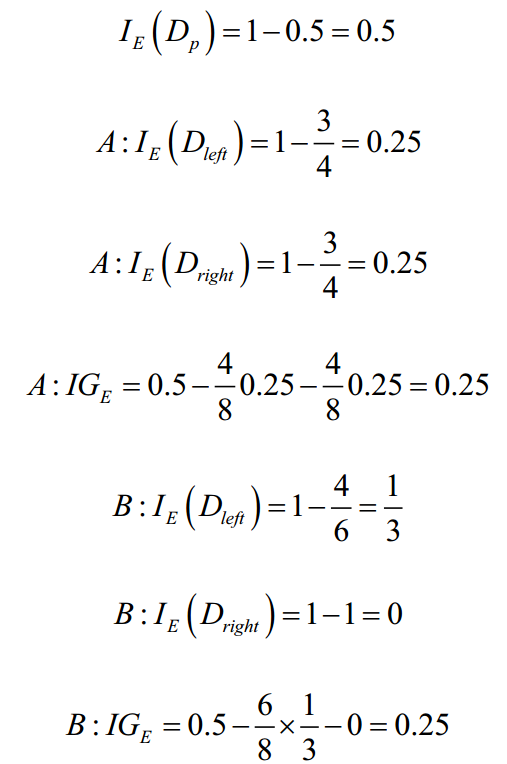

In [74]:
Image(filename='./images/03-54.png', width=300) 

### Gini不純度算法

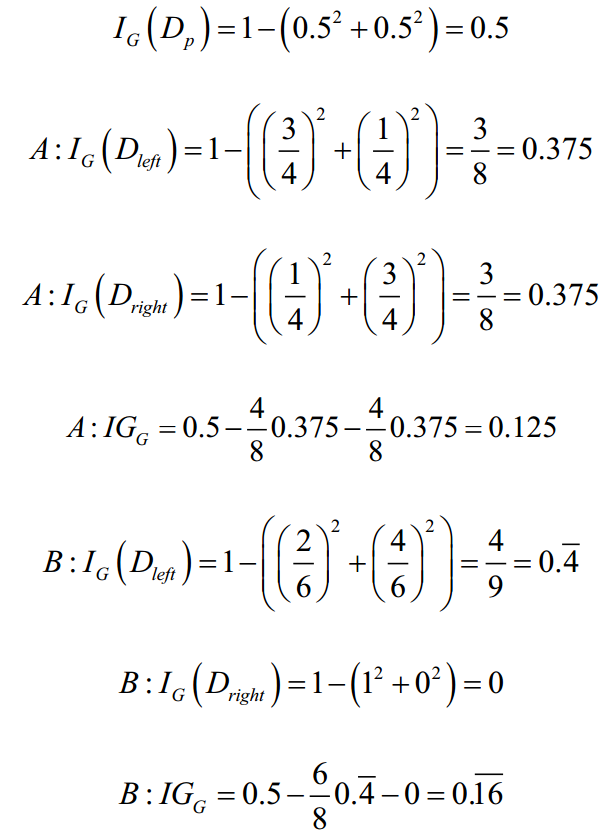

In [75]:
Image(filename='./images/03-55.png', width=300) 

### "熵"算法

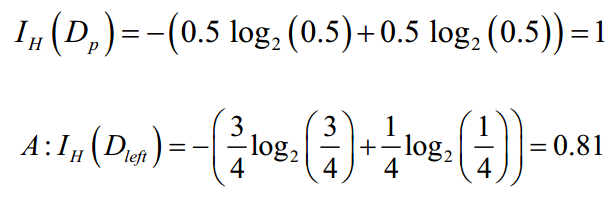

In [76]:
Image(filename='./images/03-56.png', width=300) 

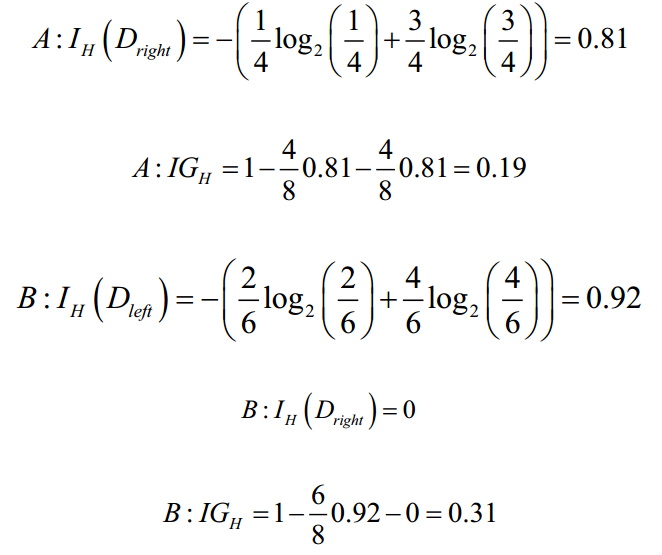

In [77]:
Image(filename='./images/03-57.png', width=300) 

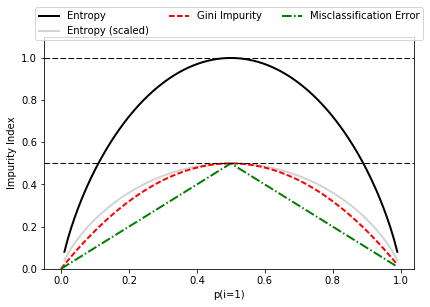

In [78]:
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.tight_layout()
#plt.savefig('./figures/impurity.png', dpi=300, bbox_inches='tight')
plt.show()

### Entropy(scaled):"熵"的正規化(熵/2)。Gini會落在熵和分類錯誤率之間

## Building a decision tree
### 越深的決策樹，會產生複雜的決策邊界這樣容易導致overfitting
### 決策樹的演算法，是不需要是先做特徵正規化

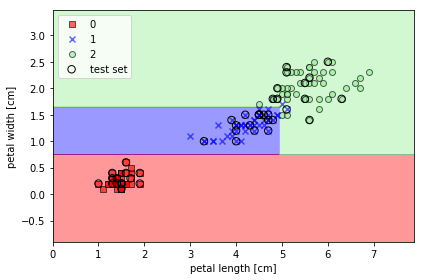

In [79]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)   #訓練一個深度最多為3的決策樹
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/decision_tree_decision.png', dpi=300)
plt.show()

<br>
<br>

In [80]:
from sklearn.tree import export_graphviz     #graphviz 將Tree視覺化，需要用GraphViz的軟體才能開啟

export_graphviz(tree, 
                out_file='tree.dot',         #輸出圖檔，圖檔如下
                feature_names=['petal length', 'petal width'])

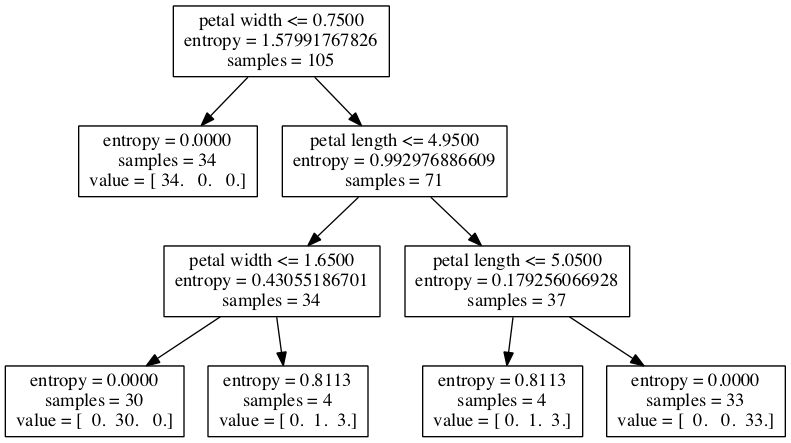

In [81]:
Image(filename='./images/03_18.png', width=600) 

**Note**

If you have scikit-learn 0.18 and pydotplus installed (e.g., you can install it via `pip install pydotplus`), you can also show the decision tree directly without creating a separate dot file as shown below. Also note that `sklearn 0.18` offers a few additional options to make the decision tree visually more appealing.

<br>
<br>

## Combining weak to strong learners via random forests
## 使用隨機森林把弱學習器結合成強學習器
### 隨機森林可被視為多個決策樹結合成一個"整體"(ensemble)，整體學習是結合多個弱學習器來建構一個更堅固的模型-強學習器。強固模型的"一般化誤差"較低，也不會產生overfitting
### ---
## 隨機森林演算法為以下4步驟
### 1. 定義大小為n的隨機自助(bootstrap)樣本(從訓練數據集中隨機選擇n個樣本，採用"放回式"，取出後放回)
### 2. 從自助樣本導出決策樹。對每個節點:(一般決策樹的處理方式)
####   a.選隨機選擇d個特徵(採"不放回式"，取出不放回)
####   b.使用特徵分割該節點，依據目標函數找到最佳方式，EX:最大化"資訊增益"
### 3. 重複k次步驟1~2
### 4. 匯所有決策樹的預測，以多數決的方式，來指定類別標籤   (CH7 有詳細說明)
### ----
### 隨機森林的優勢是，我們不需要修剪隨機森林，因為整體學習是非常堅固，個別決策樹的雜訊不會影響整體結果，我們需要關心的是決策樹的數量k、決策樹的數量越多，隨機森林的效能越好，但是成本會提高

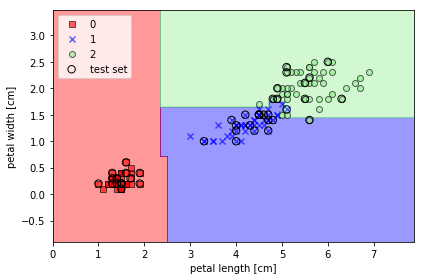

In [82]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10,    #10棵決策樹
                                random_state=1,     
                                n_jobs=2)           #使用的CPU的核心數
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/random_forest.png', dpi=300)
plt.show()

<br>
<br>

# K-nearest neighbors - a lazy learning algorithm
### KNN演算法
### 1. 選定k的值和距離度量(distance metric)
### 2. 找出k個，我們想分類的最相近的鄰近樣本
### 3. 以多數決的方是指定類別標籤
### ----
### 下圖是利用5個最近的鄰居，以多數決的方式，而被指定為三角形的類別

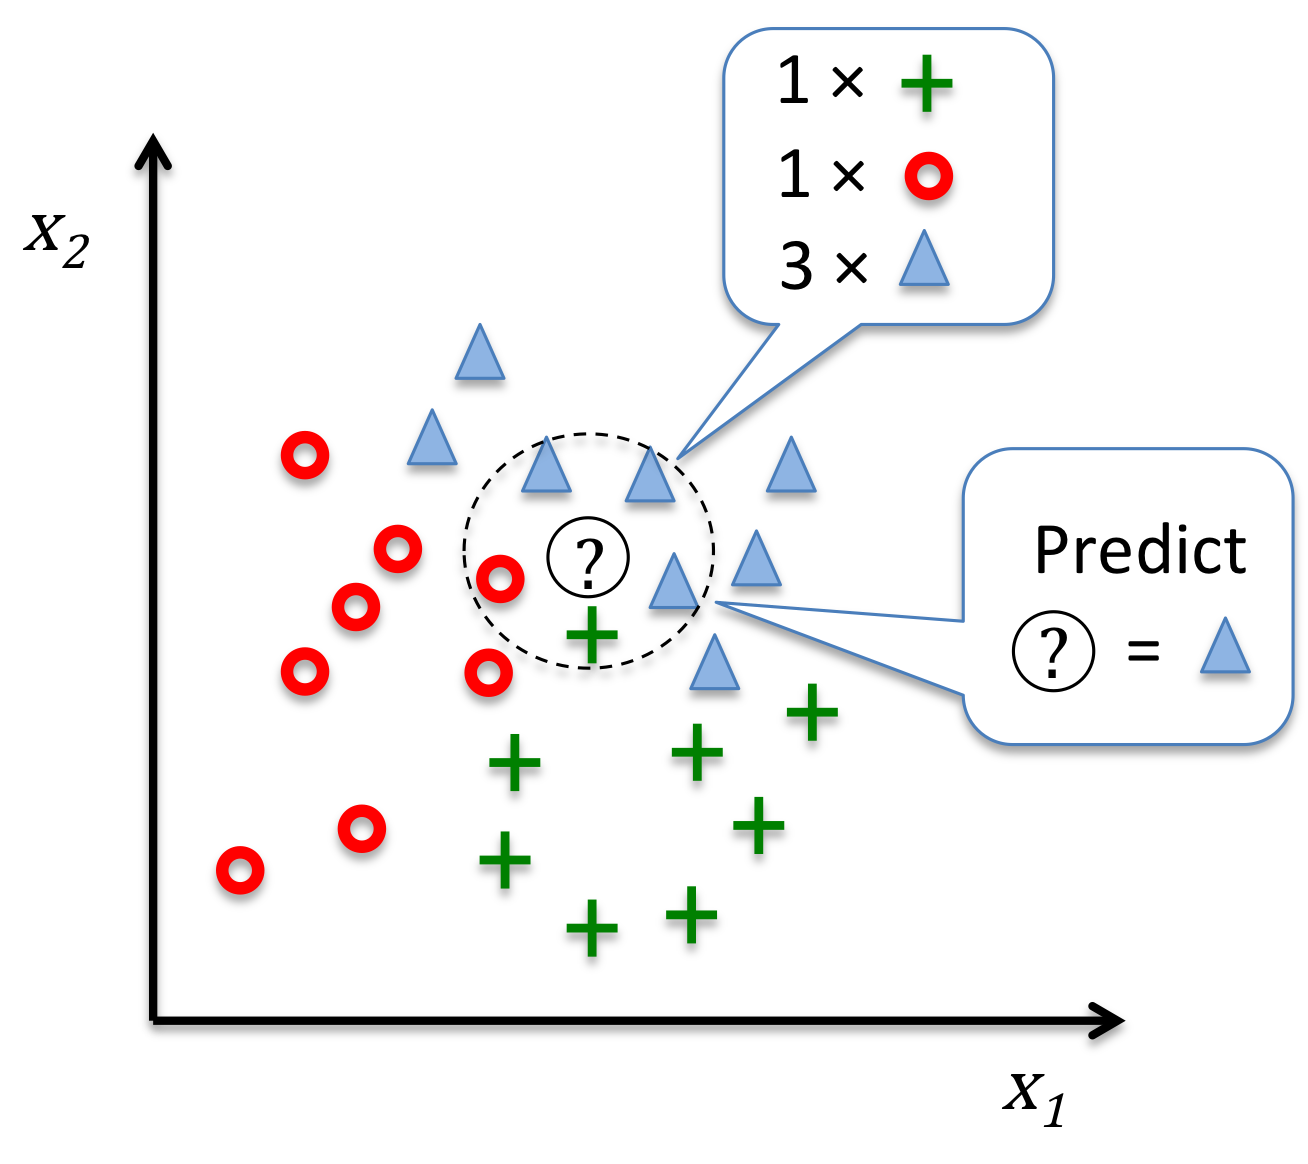

In [83]:
Image(filename='./images/03_20.png', width=400) 

### 我們選擇的"距離度量"必須是對該訓練數據集的特徵是有意義的，通常會以"歐機李得距離"來度量樣本
### 如果我們用歐機李得距離，一個很關鍵是我們必須將特徵正規化，使每一個特徵對距離會做出相同的貢獻，以下是公式

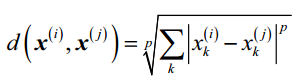

In [84]:
Image(filename='./images/03-58.png', width=300) 

## 閔可夫斯基距離(Minkowski Distance)
## p=1 曼哈頓距離
## p=2 歐式距離

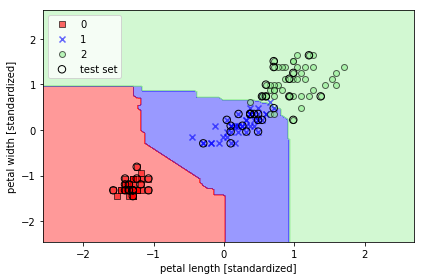

In [85]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=1, metric='minkowski')  #p=1曼哈頓距離 線只能跑直的和平的，也就是直角
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/k_nearest_neighbors.png', dpi=300)
plt.show()

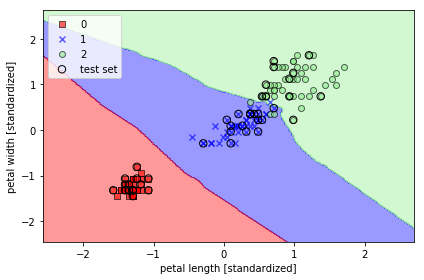

In [86]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')  #p=2 歐機李得距離 線是跑斜的
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('./figures/k_nearest_neighbors.png', dpi=300)
plt.show()

# Summary

### 如果強調資料的解釋性，可用決策樹
### 邏輯迴歸藉由隨機梯度下降建立線上學習模型，可以預測發生某一事件的發生機率
### SVM是強大的線性學習模型，並且可用核技巧，來處理非線性問題
### 以上為了得到良好的結果，有許多參數必須做調整
### 但是，隨機森林的整體學習，則不太需要做參數調整，也不會項決策樹那樣，容易overfitting
### KNN，不需要任何的訓練模名寄可做分類預測，但是成本相對高